<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd
from scipy import stats


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf

In [2]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "1pct_10k/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [3]:
links_base_case.head()

,link,from_node,to_node,length,freespeed,capacity,lanes,modes,vol_car,osm:relation:route_master,...,osm:relation:route,osm:way:railway,osm:way:name,storageCapacityUsedInQsim,osm:way:tunnel,variance,cv_percent,std_dev,std_dev_multiplied,geometry
0,100315,24972409,24972408,16.181257,8.333333,480.0,1.0,"bus,car,car_passenger",51.448980,None,...,bicycle,None,Carrefour de l'Odéon,NaN,None,21.124948,8.933488,4.596188,3.667228,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)"
1,100316,5904976363,24983651,14.860209,8.333333,480.0,1.0,"bus,car,car_passenger,pt",52.979592,None,...,bus,None,Carrefour de l'Odéon,NaN,None,24.897543,9.418237,4.989744,3.981240,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)"
2,100317,24983651,5904976363,14.860209,8.333333,960.0,2.0,"bus,car,car_passenger,pt",23.744898,None,...,bus,None,Carrefour de l'Odéon,NaN,None,5.863494,10.197834,2.421465,1.932050,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)"
3,100321,664205947,24972376,22.264540,8.333333,960.0,2.0,"car,car_passenger",60.071429,None,...,None,None,Boulevard Saint-Germain,NaN,None,28.413265,8.873452,5.330409,4.253051,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)"
4,100324,24972376,24972375,64.853276,8.333333,480.0,1.0,"bus,car,car_passenger",66.020408,None,...,bicycle,None,Rue Dupuytren,NaN,None,30.264890,8.332807,5.501353,4.389445,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)"


In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - TransformerConv(512, 64, heads=4): x,

In [5]:
# test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

# print(f"Test Loss: {test_loss}")
# print(f"R-squared: {r_squared}")
# print(f"Baseline Loss: {baseline_loss}")

# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 8
Test Loss: 3.5193258013044084
R-squared: 0.8158540725708008
Baseline Loss: 133.78128051757812


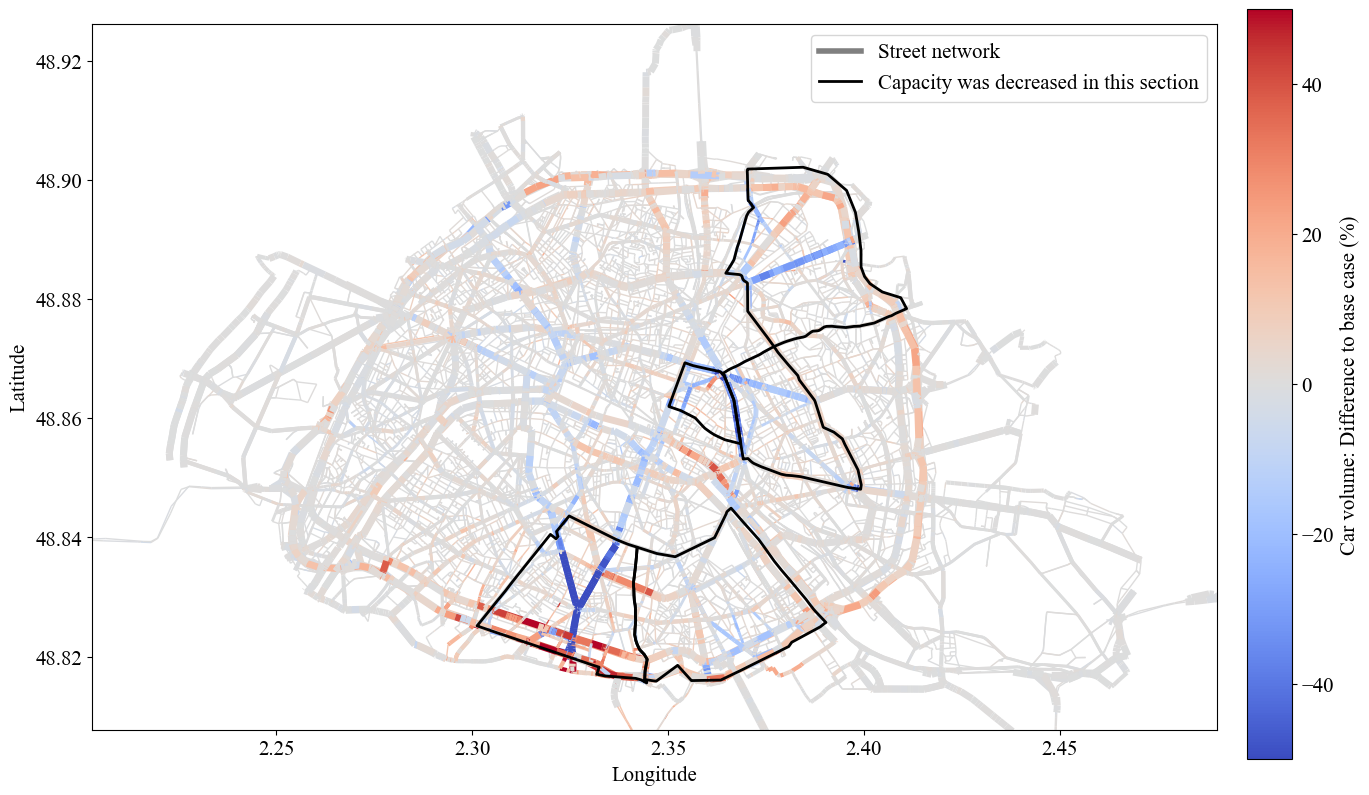

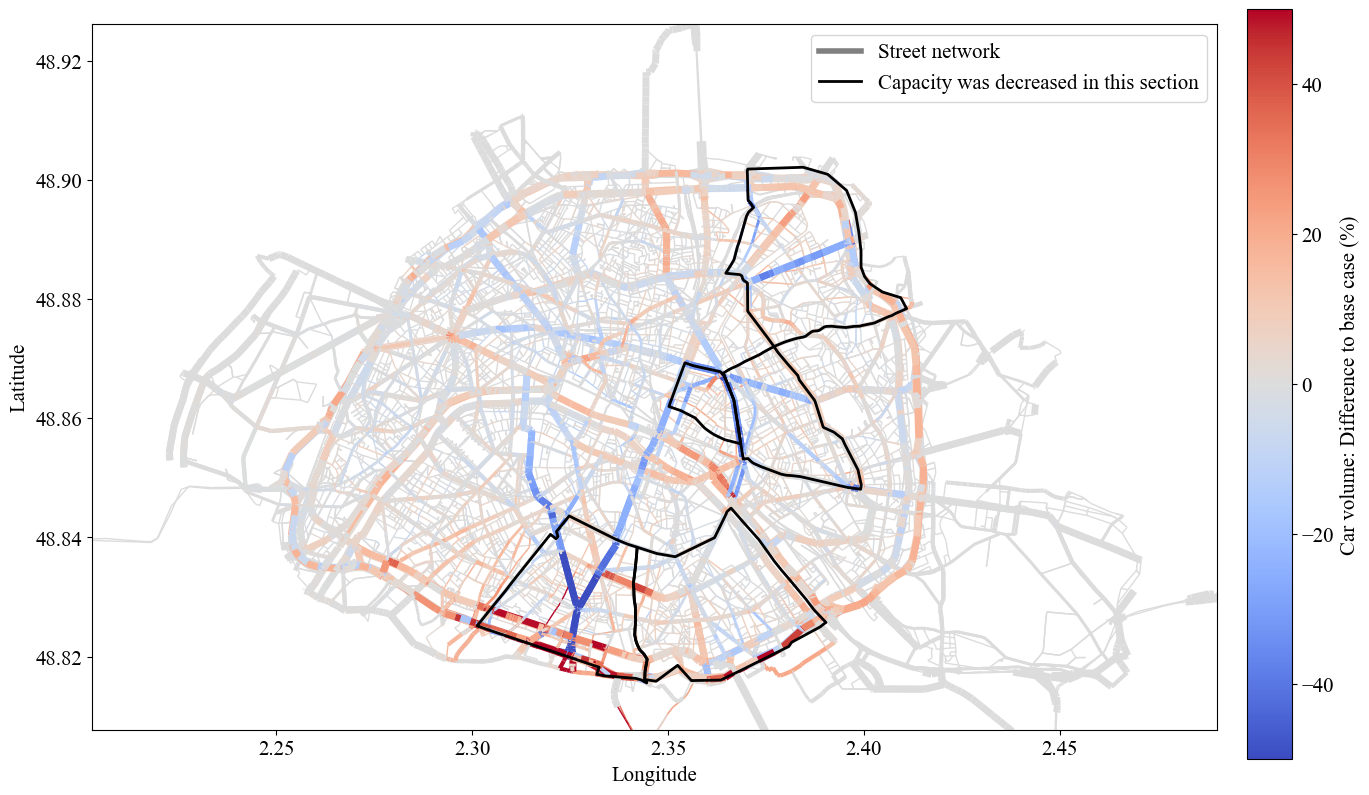

In [6]:
fixed_norm_max = 50

for i in range(10):
    if i != 8:
        continue
    # if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
    #     continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [7]:
gdf_with_og_values.head()

,from_node,to_node,vol_base_case,capacity_base_case,capacity_reduction,freespeed,highway,length,vol_car_change_actual,vol_car_change_predicted,mean_car_vol,variance,std_dev,std_dev_multiplied,cv_percent,geometry,capacity_reduction_rounded
0,24972409,24972408,50.357143,480.0,0.0,8.333333,4.0,16.181257,3.642857,-0.994673,51.448980,21.124948,4.596188,3.667228,8.933488,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",0.0
1,5904976363,24983651,52.428571,480.0,0.0,8.333333,3.0,14.860209,-7.428571,-1.244476,52.979592,24.897543,4.989744,3.981240,9.418237,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",0.0
2,24983651,5904976363,24.047619,960.0,0.0,8.333333,3.0,14.860209,0.952381,-1.580558,23.744898,5.863494,2.421465,1.932050,10.197834,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",0.0
3,664205947,24972376,59.714286,960.0,0.0,8.333333,4.0,22.264540,2.285714,-1.473557,60.071429,28.413265,5.330409,4.253051,8.873452,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",0.0
4,24972376,24972375,66.690476,480.0,0.0,8.333333,4.0,64.853276,3.309524,-1.577794,66.020408,30.264890,5.501353,4.389445,8.332807,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",0.0


In [8]:
# Generalize the creation of gdfs for a range of indices
gdfs = []
for i in range(len(test_set_loader.dataset)):
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf['capacity_reduction_rounded'] = gdf['capacity_reduction'].round(decimals=3)
    gdf['highway'] = gdf['highway'].map(hf.highway_mapping)
    gdfs.append(gdf)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


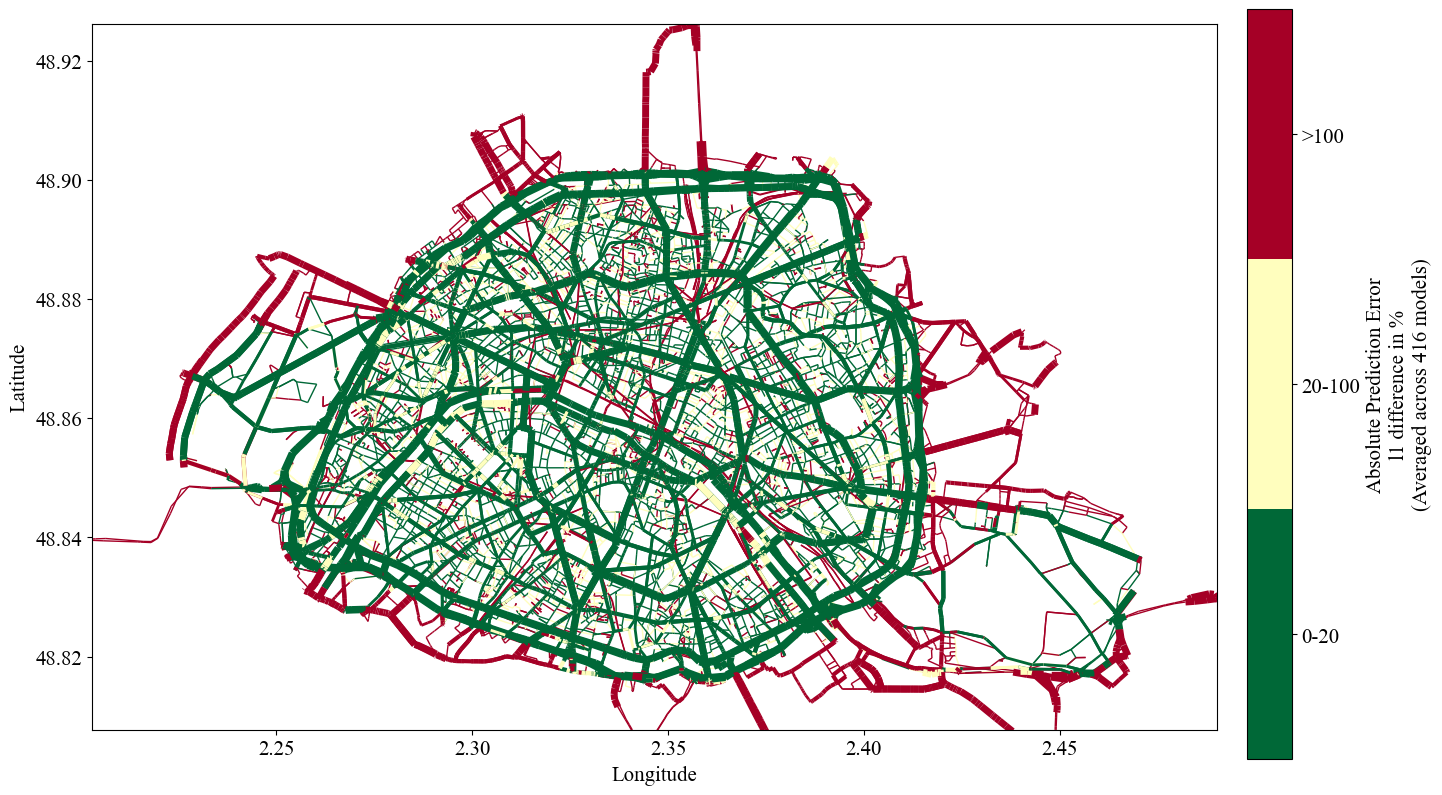

In [9]:
# For absolute differences in number of vehicles
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(20, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1"
)

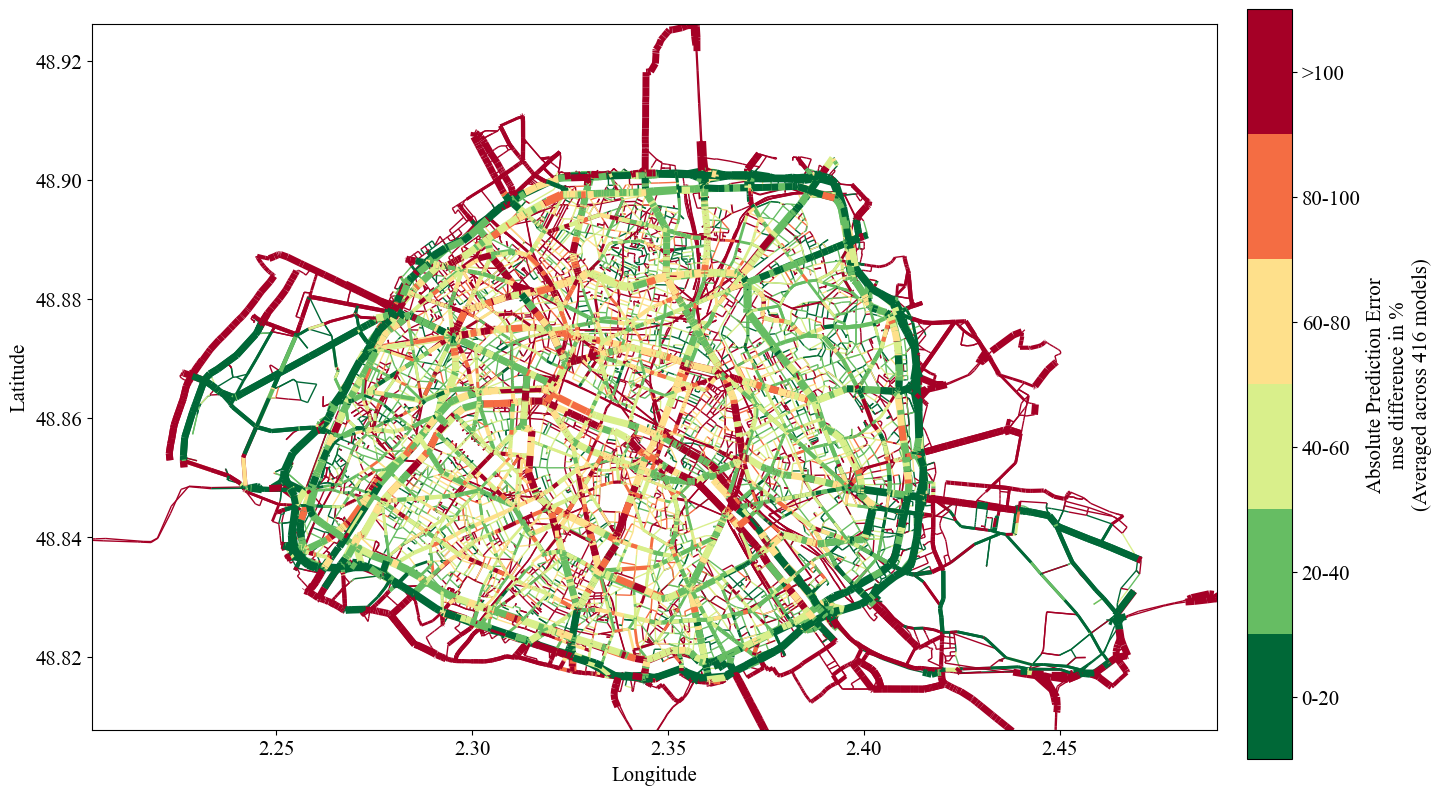

In [10]:
# For absolute differences in number of vehicles
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(20, 40, 60, 80, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="mse"
)

In [11]:
# fixed_norm_max = 50

# for i in range(100):
#     if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#                             number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

In [12]:
# PRINT ABSOLUTE CAR VOLUME

# non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
# non_zero_vol_base_case

# gdf_with_og_values['vol_car_predicted'] = (gdf_with_og_values['vol_base_case'] + gdf_with_og_values['vol_car_change_predicted'])*10
# gdf_with_og_values.head()

# non_zero_vol_base_case = gdf_with_og_values[gdf_with_og_values['vol_base_case'] != 0]
# print(non_zero_vol_base_case)

# hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
#                             fixed_norm_max = None,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, is_absolute=True)

In [13]:
indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index

tolerance = 1e-3
indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
].index
indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
    (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
    (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
].index
indices_roads_with_highway_trunk = gdf_with_og_values[gdf_with_og_values['highway'].isin([0])].index
indices_roads_with_highway_residential_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([4])].index
indices_roads_with_highway_living_street = gdf_with_og_values[gdf_with_og_values['highway'].isin([5])].index

def compute_correlations_scipy(predictions, targets):
    """
    Compute correlations using scipy (for verification)
    """
    pred_np = predictions.detach().cpu().numpy()
    target_np = targets.detach().cpu().numpy()
    
    spearman_corr, _ = stats.spearmanr(pred_np, target_np)
    pearson_corr, _ = stats.pearsonr(pred_np, target_np)
    
    return spearman_corr, pearson_corr

In [14]:
def validate_model_with_interpretable_error(indices, gdf):
    loss_fct_l2 = torch.nn.MSELoss()
    loss_fct_l1 = torch.nn.L1Loss()
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    r_squared = round(r_squared.item(), 2)
    
    mse_loss = loss_fct_l2(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    l1_loss = loss_fct_l1(torch.tensor(actual_vals), torch.tensor(predicted_vals))

    baseline_mse = loss_fct_l2(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    baseline_l1 = loss_fct_l1(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))    
    
    # Use the actual indices for these calculations too
    mean_car_vol = gdf.loc[indices, 'vol_base_case'].mean()
    variance = gdf.loc[indices, 'variance'].mean()
    std_dev = gdf.loc[indices, 'std_dev'].mean()
    std_dev_multiplied = gdf.loc[indices, 'std_dev_multiplied'].mean()
    cv_percent = gdf.loc[indices, 'cv_percent'].mean()
    
    print(f"R-squared: {r_squared}")
    print(f"MSE Loss: {mse_loss}")
    print(f"Baseline MSE Loss: {baseline_mse}")
    print(f"L1 Loss: {l1_loss}")
    print(f"Baseline L1 loss: {baseline_l1}")
    
    print(f"Mean Car Volume: {mean_car_vol}")
    print(f"Variance: {variance}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Standard Deviation Multiplied: {std_dev_multiplied}")
    print(f"Coefficient of Variation: {cv_percent}")
    print(" ")
    return

# Define road types and their corresponding indices
road_types = {
    "All Roads": gdf_with_og_values.index,
    "Trunk Roads": indices_roads_with_highway_trunk,
    "Primary Roads": indices_roads_with_highway_primary_,
    "Secondary Roads": indices_roads_with_highway_sec,
    "Tertiary Roads": indices_roads_with_highway_tertiary,
    "Residential Streets": indices_roads_with_highway_residential_street,
    "Living Streets": indices_roads_with_highway_living_street
}

# Loop through road types and validate
for road_type, indices in road_types.items():
    print(road_type)
    validate_model_with_interpretable_error(indices, gdf_with_og_values)

All Roads
R-squared: 0.82
MSE Loss: 24.63528060913086
Baseline MSE Loss: 133.78126525878906
L1 Loss: 2.6822750568389893
Baseline L1 loss: 4.20802116394043
Mean Car Volume: 50.908044134359926
Variance: 8.570391818197557
Standard Deviation: 2.097115607525589
Standard Deviation Multiplied: 1.6732561654633888
Coefficient of Variation: 19.472651081093208
 
Trunk Roads
R-squared: 0.63
MSE Loss: 88.07875061035156
Baseline MSE Loss: 238.12945556640625
L1 Loss: 5.663949489593506
Baseline L1 loss: 10.645626068115234
Mean Car Volume: 484.6030725259021
Variance: 18.322837081548283
Standard Deviation: 3.603087633418326
Standard Deviation Multiplied: 2.8748479939242175
Coefficient of Variation: 4.798760132112466
 
Primary Roads
R-squared: 0.91
MSE Loss: 53.02848815917969
Baseline MSE Loss: 578.33349609375
L1 Loss: 4.657049179077148
Baseline L1 loss: 11.273927688598633
Mean Car Volume: 114.89886685552408
Variance: 19.216427310937096
Standard Deviation: 3.6477072939845017
Standard Deviation Multiplied

In [15]:
# Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
gdf_in_meters['length'] = gdf_in_meters.length
total_length = gdf_in_meters['length'].sum() / 1000
print(f"Total length of the street network: {total_length:.2f} km")
gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")

Total length of the street network: 2872.02 km
Total length of the street network with capacity reductions: 210.73 km


In [17]:
def validate_model_with_interpretable_error(indices, gdf):
    loss_fct_l2 = torch.nn.MSELoss()
    loss_fct_l1 = torch.nn.L1Loss()
    actual_vals = gdf.loc[indices, 'vol_car_change_actual']
    predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
    
    actual_vals = actual_vals.to_numpy()
    predicted_vals = predicted_vals.to_numpy()
    actual_mean = torch.mean(torch.tensor(actual_vals))
    r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    r_squared = round(r_squared.item(), 2)
    
    mse_loss = loss_fct_l2(torch.tensor(actual_vals), torch.tensor(predicted_vals))
    l1_loss = loss_fct_l1(torch.tensor(actual_vals), torch.tensor(predicted_vals))

    baseline_mse = loss_fct_l2(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
    baseline_l1 = loss_fct_l1(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))    
    
    # Use the actual indices for these calculations too
    mean_car_vol = gdf.loc[indices, 'vol_base_case'].mean()
    variance = gdf.loc[indices, 'variance'].mean()
    std_dev = gdf.loc[indices, 'std_dev'].mean()
    std_dev_multiplied = gdf.loc[indices, 'std_dev_multiplied'].mean()
    cv_percent = gdf.loc[indices, 'cv_percent'].mean()
    
    # Print results as before
    print(f"MSE Loss: {mse_loss}")
    print(f"Baseline MSE Loss: {baseline_mse}")
    print(f"L1 Loss: {l1_loss}")
    print(f"Baseline L1 loss: {baseline_l1}")
    print(f"Mean Car Volume: {mean_car_vol}")
    print(f"Variance: {variance}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Normalized Standard Deviation: {std_dev_multiplied}")
    print(" ")
    
    return {
        'mse': mse_loss.item(),
        'naive_mse': baseline_mse.item(),
        'l1': l1_loss.item(),
        'naive_l1': baseline_l1.item(),
        'variance': variance,
        'std_dev': std_dev,
        'std_dev_normalized': std_dev_multiplied,
        'mean_car_vol': mean_car_vol,
        'r_squared': r_squared,
        'cv_percent': cv_percent
    }

# Collect metrics for each road type
metrics_by_type = {}
for road_type, indices in road_types.items():
    print(road_type)
    metrics_by_type[road_type] = validate_model_with_interpretable_error(indices, gdf_with_og_values)
    print(metrics_by_type[road_type])


All Roads
MSE Loss: 24.63528060913086
Baseline MSE Loss: 133.78126525878906
L1 Loss: 2.6822750568389893
Baseline L1 loss: 4.20802116394043
Mean Car Volume: 50.908044134359926
Variance: 8.570391818197557
Standard Deviation: 2.097115607525589
Normalized Standard Deviation: 1.6732561654633888
 
{'mse': 24.63528060913086, 'naive_mse': 133.78126525878906, 'l1': 2.6822750568389893, 'naive_l1': 4.20802116394043, 'variance': 8.570391818197557, 'std_dev': 2.097115607525589, 'std_dev_normalized': 1.6732561654633888, 'mean_car_vol': 50.908044134359926, 'r_squared': 0.82, 'cv_percent': 19.472651081093208}
Trunk Roads
MSE Loss: 88.07875061035156
Baseline MSE Loss: 238.12945556640625
L1 Loss: 5.663949489593506
Baseline L1 loss: 10.645626068115234
Mean Car Volume: 484.6030725259021
Variance: 18.322837081548283
Standard Deviation: 3.603087633418326
Normalized Standard Deviation: 2.8748479939242175
 
{'mse': 88.07875061035156, 'naive_mse': 238.12945556640625, 'l1': 5.663949489593506, 'naive_l1': 10.645

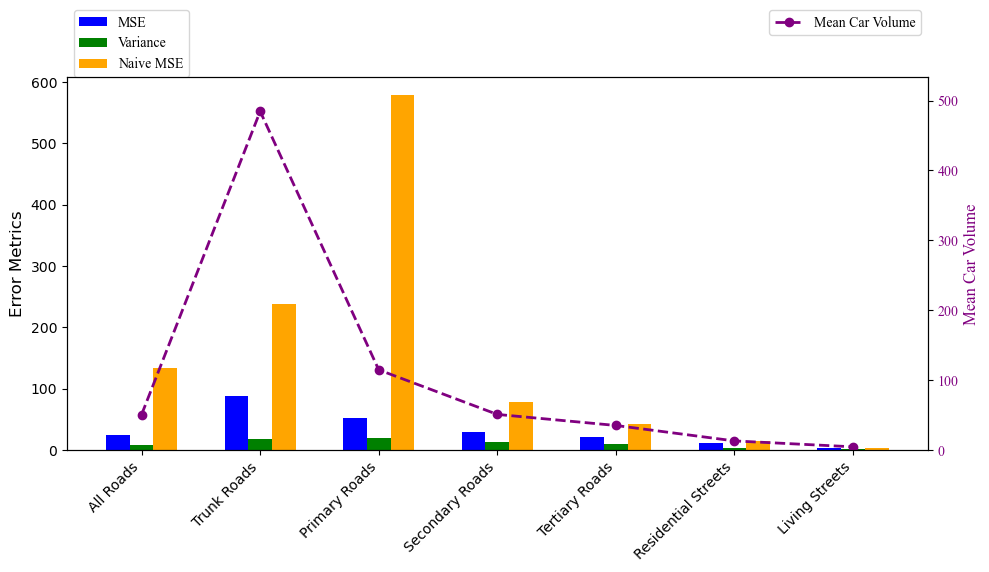

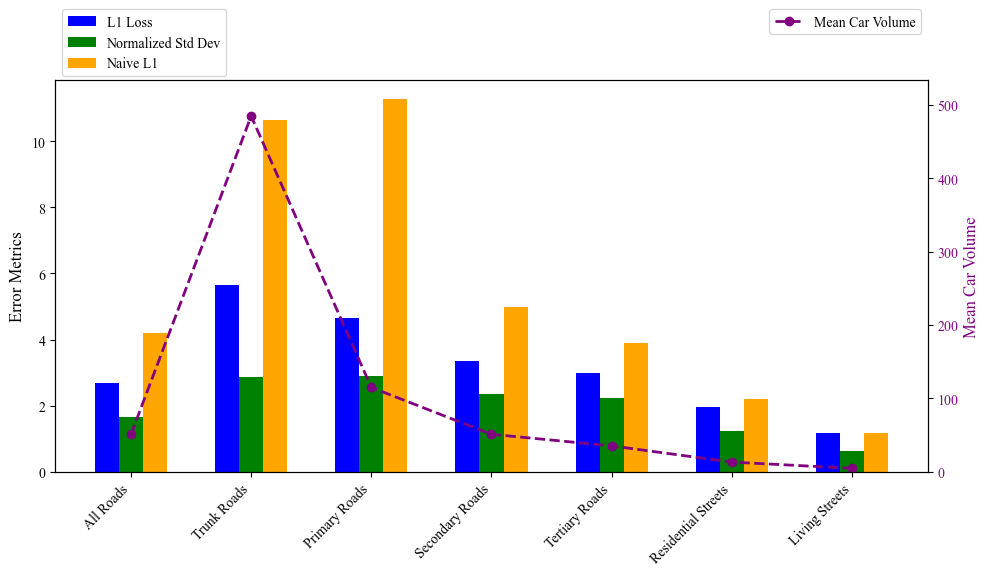

In [19]:
# Plot 1: MSE vs Variance
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

x = np.arange(len(road_types))
bar_width = 0.2

# Bar plot for MSE, Variance, and Naive MSE
ax1.bar(x - bar_width, [metrics_by_type[rt]['mse'] for rt in road_types], 
        width=bar_width, label="MSE", color="blue")
ax1.bar(x, [metrics_by_type[rt]['variance'] for rt in road_types], 
        width=bar_width, label="Variance", color="green")
ax1.bar(x + bar_width, [metrics_by_type[rt]['naive_mse'] for rt in road_types], 
        width=bar_width, label="Naive MSE", color="orange")
ax1.set_ylabel("Error Metrics", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(road_types, rotation=45, ha="right")
ax1.legend(loc="upper left", fontsize=10, bbox_to_anchor=(0, 1.2))

# Second y-axis for Mean Car Volume
ax2 = ax1.twinx()
ax2.plot(x, [metrics_by_type[rt]['mean_car_vol'] for rt in road_types], 
         label="Mean Car Volume", color="purple", marker="o", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Mean Car Volume", fontsize=12, color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.set_ylim(0, max([metrics_by_type[rt]['mean_car_vol'] for rt in road_types]) * 1.1)
ax2.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1, 1.2))

plt.savefig("mse_vs_variance.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

# Plot 2: L1 vs Normalized Standard Deviation
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

# Bar plot for L1, Normalized Std Dev, and Naive L1
ax1.bar(x - bar_width, [metrics_by_type[rt]['l1'] for rt in road_types], 
        width=bar_width, label="L1 Loss", color="blue")
ax1.bar(x, [metrics_by_type[rt]['std_dev_normalized'] for rt in road_types], 
        width=bar_width, label="Normalized Std Dev", color="green")
ax1.bar(x + bar_width, [metrics_by_type[rt]['naive_l1'] for rt in road_types], 
        width=bar_width, label="Naive L1", color="orange")
ax1.set_ylabel("Error Metrics", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(road_types, rotation=45, ha="right")
ax1.legend(loc="upper left", fontsize=10, bbox_to_anchor=(0, 1.2))

# Second y-axis for Mean Car Volume
ax2 = ax1.twinx()
ax2.plot(x, [metrics_by_type[rt]['mean_car_vol'] for rt in road_types], 
         label="Mean Car Volume", color="purple", marker="o", linestyle="dashed", linewidth=2)
ax2.set_ylabel("Mean Car Volume", fontsize=12, color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.set_ylim(0, max([metrics_by_type[rt]['mean_car_vol'] for rt in road_types]) * 1.1)
ax2.legend(loc="upper right", fontsize=10, bbox_to_anchor=(1, 1.2))

plt.savefig("l1_vs_normalized_std_dev.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()